# Use case: Studying the Greenhouse Effect produced by the water vapour

## Quality assessment question:
 - __Can Satellite measurements reproduce the known relationship between clear sky greenhouse effect and total column water vapour (TCWV)?__

## Abstract


The water vapour is the most significant anthropogenic greenhouse gases, contributing to about half of the planet's overall greenhouse effect [[1]](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2010JD014287). As a result, it plays a significant in influencing the Earth's radiation budget, with its radiative forcing being directly proportional to its total amount in the atmosphere.

Furthermore, the warming induced by an increase in CO2 concentrations is expected to lead to higher levels of water vapor through the Clausius-Clapeyron relationship [[2]](https://doi.org/10.1175/1520-0469\(1967\)024<0241:TEOTAW>2.0.CO;2). The increasing of water vapor, in turn, intensifies the greenhouse effect, a phenomenon referred to as the water vapor feedback [[3]](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2000JD000040). This positive feedback mechanism underscores the critical importance of monitoring and comprehending the water vapour concentrations to accurately assess and predict its impacts on the Earth's climate system.


In this analysis, we study the greenhouse warming induced by water vapor and aim to determine the relationship between the two variables. We quantify the amount of water vapor in the atmosphere using its vertially integrated value, known as Total Columns Water Vapor (TCWV), which is obtained from satellite observations. The data used in this study is __Global monthly and daily high-spatial resolution of total column water vapour from 2002 to 2017 derived from satellite observations__, available on the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S).


## Quality assessment statement 

These are the key outcomes of this assessment

- The clear sky greenhouse effect is approximately a linear function of the total column water vapour. The exact values of greenhouse effect and the value of the slope are in agreement with [[3]](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2000JD000040).

- An estimate of the water vapour feedback is given by assuming a constant lapse rate and a fixed Clausius–Clapeyron rate at different altitudes. The humidity feedback obtained is $2.5 \pm 0.2$ $W/m^{2}/ K$ which is in agreement with the IPCC [[4]](https://www.ipcc.ch/report/ar6/wg1/downloads/report/IPCC_AR6_WGI_Chapter07.pdf).

- The agreement with [[3]](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2000JD000040) proves also that the datasets of cloud amount [here](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-cloud-properties), sea surface temperature [here](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-surface-temperature), and outgoing longwave radiation [here](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-earth-radiation-budget) on CDS, are accurate and reliable.



## Methodology

The relationship between clear sky Greenhouse effect and Total Column of Water Vapour (TCWV) is examined using the available datasets from the Climate Data Record (CDR) for clouds, Sea Surface Temperature, and Outgoing Longwave Radiation (OLR), detailed below. These datasets are daily and the analysis focuses on the tropical ocean over January 2007.

Initially, clear sky regions are identified for each day. Surface emissions are estimated from the sea surface temperature using black body radiation, because water has a large emissivity in the infrared spectrum. Then, the Greenhouse effect is computed by subtracting the OLR from the surface emission:
\begin{equation}
\text{Greenhouse Effect} = \text{OLR} - \sigma T^4
\end{equation}
The Greenhouse warming is then compared with TCWV, and their relationship is visualized as a function of TCWV.
Lastly, the derived relationship is utilized to estimate the water vapour feedback.


The analysis comprises the following steps:

__1. [Choose the data to use and setup code](#Choose-the-data-to-use-and-setup-code)__
 - Import the relevant packages. Define the parameters of the analysis and set the dataset requests

__2. [Download the datasets](#Download-the-datasets)__
 - Download the variables of interest: TCWV is obtained from __Global monthly and daily high-spatial resolution of total column water vapour from 2002 to 2017 derived from satellite observations__, Clear sky is obtained from __Cloud properties global gridded monthly and daily data from 1979 to present derived from satellite observations__, Surface Temperature is obtained from __Sea surface temperature daily data from 1979 to present derived from satellite observations__, Outgoing Longwave Radiation (OLR) is obtained from __Earth's radiation budget from 1979 to present derived from satellite observations__.

__3.[Colocate and compute the clear sky greenhouse effect](#Colocate-and-compute-the-clear-sky-greenhouse-effect)__
 -  The datasets are colocated in space over the Indian Ocean. Gridboxes with clear coverage greater than 20% are rejected. Moreover, only the well retrieved TCWV and surface temperature are considered. The amount of radiation emitted by the surface is computed assuming blackbody behavior of the ocean. Then, the greenhouse effect is obtained by subtracting outging lonwave radiation and surface emission.
   
__4. [Plot and describe results](#Plot-and-describe-results)__
 - The greenhouse warming is plotted as a function of the TCWV. A linear regression is computed and the value of the slope is used to estimate the special humidity feedback. Final results are compared with proper references.



## Analysis and Results

### Choose the data to use and setup code

#### Import packages

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from scipy.stats import linregress
import numpy as np 
from c3s_eqc_automatic_quality_control import diagnostics, download, plot

import os
os.environ["CDSAPI_RC"] = os.path.expanduser("~/mandorli_giulio/.cdsapirc")

#### Define prameters

In [2]:
# Time
start = "2007-01"
stop = "2007-01"

# Region: Degree range has to be integers because UTH has a resolution of 1x1
lat_min = -30
lat_max = 30
lon_min = -180
lon_max = 180

#### Set the data request

In [3]:
chunks = {"year": 1, "month": 1}
requests = dict()

requests["satellite-total-column-water-vapour-land-ocean"] = {
        'variable': 'all',
        'horizontal_aggregation': '0_5_x_0_5',
        'temporal_aggregation': 'daily',
        'product': 'near_infrared_hoaps_combined',
}

requests["satellite-cloud-properties"] = {
        'product_family': 'clara_a2',
        'origin': 'eumetsat',
        'variable': 'cloud_fraction',
        'climate_data_record_type': 'thematic_climate_data_record',
        'time_aggregation': 'daily_mean',
}


requests["satellite-sea-surface-temperature"] = {
        'version': '2_1',
        'variable': 'all',
        'sensor_on_satellite': 'combined_product',
        'processinglevel': 'level_4',
}


requests["satellite-earth-radiation-budget"] = {
    'product_family': 'clara_a3',
    'origin': 'eumetsat',
    'variable': 'outgoing_longwave_radiation',
    'climate_data_record_type': 'thematic_climate_data_record',
    'time_aggregation': 'daily_mean',
}




### Download the datasets

In [4]:
datasets = {}

for collection_id in requests :
    request = requests[collection_id]
    datasets[collection_id] =  download.download_and_transform(
                                    collection_id,
                                    download.update_request_date(request | {'area': [lat_min, lon_min, lat_max, lon_max]}, 
                                                                 start, 
                                                                 stop, 
                                                                 stringify_dates=True),
                                        chunks=chunks,
                                    )
    



100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


### Colocate and compute the clear sky greenhouse effect

In [5]:
DS_CLOUDS = datasets["satellite-cloud-properties"].coarsen(latitude=4, longitude=4).mean().compute()
DS_TEMP   = datasets["satellite-sea-surface-temperature"].coarsen(latitude=20, longitude=20).mean().compute()
DS_TOA    = datasets["satellite-earth-radiation-budget"].coarsen(latitude=4, longitude=4).mean().compute()

ds_TCWV   = datasets["satellite-total-column-water-vapour-land-ocean"]
DS_TCWV   = ds_TCWV.reindex(latitude=list(reversed(ds_TCWV.latitude)))
DS_TCWV   = DS_TCWV.coarsen(latitude=2, longitude=2).mean().compute()


In [6]:
series = {}
for da in [DS_TCWV["tcwv"], DS_TEMP["analysed_sst"], DS_TOA["LW_flux"], DS_CLOUDS["cfc_day"], DS_CLOUDS["cfc_night"]]:
    series[da.name] = (
        da.sortby(list(da.dims))
        .stack(index=sorted(da.dims))
        .to_series()
        .reset_index(drop=True)
    )

# Selection of clear sky region and correctly retrieved surface temperature and TCVW
df = pd.DataFrame(series).query('cfc_day + cfc_night < 40')
df = df.query('(analysed_sst>0) & (tcwv>0)')

df['Greenhouse_effect'] =  5.67 / 100_000_000. * df['analysed_sst'] ** 4 - df['LW_flux']

#### Plot and describe results

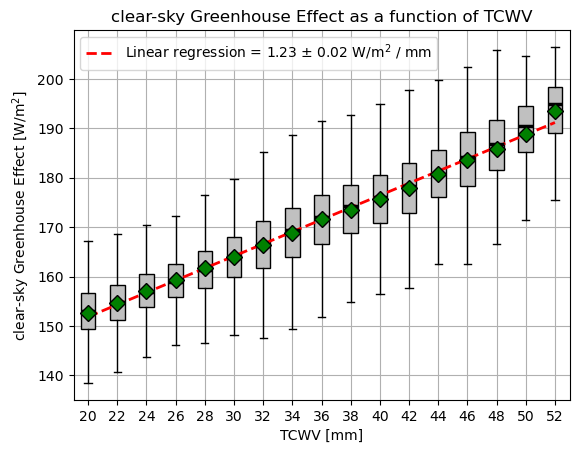

In [7]:
bin_edges = range(19, 55, 2)
#bin_edges = np.linspace(15, 60, (60-15)+1)
bin_labels = pd.Series(bin_edges).rolling(2).mean()[1:]
grouper = pd.cut(df["tcwv"], bin_edges)
ax = df.groupby(grouper, observed=False).boxplot(
    subplots=False,
    column="Greenhouse_effect",
    showfliers=False,
    patch_artist=True,
    showmeans=True,
    medianprops={"linewidth": 2.5, "color": "k"},
    meanprops={
        "marker": "D",
        "markeredgecolor": "black",
        "markerfacecolor": "green",
        "markersize": 8,
    },
    whiskerprops={"color": "k"},
    boxprops={"color": "k", "facecolor": "silver"},
    xlabel="TCWV [mm]",
    ylabel="clear-sky Greenhouse Effect [W/m$^2$]",
    grid=True,
)


# Get all mean values
x_data = np.array([(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(len(bin_labels))])
y_data = df.groupby(grouper, observed=False).mean()['Greenhouse_effect'].to_numpy()

# Perform linear regression
slope, intercept, r, p, se = linregress(x_data, y_data)


# Plot linear fit
ax.plot(
    np.arange(x_data.size)+1,
    slope * x_data + intercept,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Linear regression = {slope:.2f} $\pm$ {se:.2f} W/m$^2$ / mm",
)


ax.set_title("clear-sky Greenhouse Effect as a function of TCWV")
ax.set_xticklabels(bin_labels.astype(int))

plt.legend()

plt.show()

# Variables to estimate the specific humidity radiative feedback
TCWV_mean = df.tcwv.mean()
feedback = slope * TCWV_mean * 0.07
#print(f"feedback: {feedback:.2f}")

*This boxplot illustrates the distribution of the clear sky Greenhouse Effect within various Total Column of Water Vapour (TCWV) bins. The green rhombs show the statistic of the Greenhouse Effect for each bin. A linear regression has been applied to the dataset, visualized by the red curve and reported in the legend.*

The results show a linear relationship between the clear sky greenhouse effect and the Total Columns of Water Vapour, in agreement with previous research [[3]](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2000JD000040).

The relationship between clear sky Greenhouse Effect and TCWV is studied on the time scale of one day. However, since it is linear, the same relationship must be valid over larger spatial and temporal scales. In particular, this is also the relationship between the climatological Greenhouse effect and TCWV, and it can be used to estimate the water vapour feedback.



Water vapour scales in accordance with the Clausius–Clapeyron (CC) relationship. Although the CC rate varies with altitude, it typically falls within the range of 6.5% to 7.5%. Moreover, under the assumption of a constant lapse rate and a constant relative humidity:

\begin{align}
\text{Water Vapour feedback} &= \frac{d G}{d TCWV}\frac{d TCWV}{dT} \\
 &= \frac{d G}{d TCWV}  <TCWV>  CC \\
 &= 1.23 \, W/m^{2}/mm \cdot 29 \, mm \cdot 0.07 \, K^{-1} \\
 &= 2.5 \pm 0.2 \quad  W/m^{2}/ K
\end{align}

Where $G$ is the clear sky Greenhouse Effect, the average TCWV is 29 mm, and the adopted CC rate is $(7 \pm 0.5) \%$.
This result is in agreement with Fig.20 of IPCC report Chapter 7 [[4]](https://www.ipcc.ch/report/ar6/wg1/downloads/report/IPCC_AR6_WGI_Chapter07.pdf)



## If you want to know more
### Key resources
Some key resources and further reading were linked throughout this assessment.

The CDS catalogue entries for the data used is:
- Global monthly and daily high-spatial resolution of total column water vapour from 2002 to 2017 derived from satellite observations: https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-total-column-water-vapour-land-ocean

Code libraries used:
- [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`, prepared by [BOpen](https://www.bopen.eu/)


### Reference/Useful material
[[1]](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2010JD014287) Schmidt, G. A., R. A. Ruedy, R. L. Miller, and A. A. Lacis (2010), Attribution of the present‐day total greenhouseeffect,J. Geophys. Res.,115, D20106, doi:10.1029/2010JD014287


[[2]](https://doi.org/10.1175/1520-0469(1967)024<0241:TEOTAW>2.0.CO;2) Manabe, S., and R. T. Wetherald, 1967: Thermal Equilibrium of the Atmosphere with a Given Distribution of Relative Humidity. J. Atmos. Sci., 24, 241–259, https://doi.org/10.1175/1520-0469(1967)024<0241:TEOTAW>2.0.CO;2. 

[[3]](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2000JD000040)  Roca, R., M. Viollier, L. Picon, and M. Desbois, A multisatellite analysis of deep convection and its moist environment over the Indian Ocean during the winter monsoon, J. Geophys. Res., 107(D19), doi:10.1029/2000JD000040, 2002.

[[4]](https://www.ipcc.ch/report/ar6/wg1/downloads/report/IPCC_AR6_WGI_Chapter07.pdf)  Forster, P., T. Storelvmo, K. Armour, W. Collins, J.-L. Dufresne, D. Frame, D.J. Lunt, T. Mauritsen, M.D. Palmer, M. Watanabe, M. Wild, and H. Zhang, 2021: The Earth’s Energy Budget, Climate Feedbacks, and Climate Sensitivity. In Climate Change 2021: The Physical Science Basis. Contribution of Working Group I to the Sixth Assessment Report of the Intergovernmental Panel on Climate Change [Masson-Delmotte, V., P. Zhai, A. Pirani, S.L. Connors, C. Péan, S. Berger, N. Caud, Y. Chen, L. Goldfarb, M.I. Gomis, M. Huang, K. Leitzell, E. Lonnoy, J.B.R. Matthews, T.K. Maycock, T. Waterfield, O. Yelekçi, R. Yu, and B. Zhou (eds.)]. Cambridge University Press, Cambridge, United Kingdom and New York, NY, USA, pp. 923–1054, doi: 10.1017/9781009157896.009.


[[5]](https://doi.org/10.3390/rs11030251)  Schröder, Marc, Maarit Lockhoff, Lei Shi, Thomas August, Ralf Bennartz, Helene Brogniez, Xavier Calbet, Frank Fell, John Forsythe, Antonia Gambacorta, and et al. 2019. "The GEWEX Water Vapor Assessment: Overview and Introduction to Results and Recommendations" Remote Sensing 11, no. 3: 251. https://doi.org/10.3390/rs11030251

